##### BNS-DTD-from-rprocess.ipynb
### *constraints on binary neutron star delay times from galactic r-process abundance observations*

this notebook plots posterior samples (tmin,alpha) ~ P(tmin,alpha|d) in binary neutron star delay time distribution parameters, conditioned on r-process abundance measurements from galactic stellar spectra, merger rate constraints from gravitational-wave surveys, ejecta expectations from numerical relativity and information about short gamma-ray burst delay times

##### philippe landry (pgjlandry@gmail.com) 02/2024

In [1]:
# import packages

import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal, gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import time
from tqdm import tqdm

from multiprocessing import Pool
import multiprocessing

from etc.rProcessUtils import rho_MW
from etc.rProcessChemicalEvolution import rproc_evolution

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# user input

NSAMP = 500 # number of delay time distribution parameter samples to build kde out of

DTDPATH = 'etc/Zevin22_sgrb_dtd.dat' # path to delay time distribution parameter samples
EJPATH = 'etc/mej_rate_lcehl_psr+gw+nicer.dat' # path to rate and ejecta samples

OBSPATH = 'etc/Battistini16_disk.csv' # path to disk star observations
OBSPATH2 = 'etc/SAGA_MP.csv' # path to disk+halo star observations

SOLARPATH = 'etc/Arnould07_solar_rprocess.dat' # path to solar r-process abundances

FEH_MIN, FEH_MAX = (-3.,0.5)
NFEH = int((FEH_MAX-FEH_MIN)/0.05) # Fe grid spacing for confidence intervals

NSTP = 3 # number of subdivisions per time step in chemical evolution integration

In [3]:
# load DTD parameter and rate-mej samples

alpha, tdmin, tdmax = np.loadtxt(DTDPATH, unpack=True, skiprows=1) # [], [yr], [yr]
tdmin = tdmin/1e9 # convert to Gyr
idxs = np.random.choice(range(len(alpha)),NSAMP,False) # jointly sample in alpha, tmin
alphas = alpha[idxs]
tdmins = tdmin[idxs]

mej_dyn, mej_dsk, rate = np.loadtxt(EJPATH, unpack=True) # [Msun], [Msun], [MW^-1 Myr^-1]
mej = mej_dyn + mej_dsk
rate = rate*(1e9*rho_MW)/1e6 # convert to Gpc^-3 yr^-1
idxs = np.random.choice(range(len(mej)),NSAMP,False) # jointly sample in rate, mej
rates = rate[idxs]
mejs = mej[idxs]

samples = pd.DataFrame(np.column_stack((alphas,np.log10(tdmins*1e3),rates*mejs*1e6/(1e9*rho_MW)))) # [], [Myr], [MW^-1 Myr^-1]
samples.columns = ['alpha','log10tmin','ratemej']

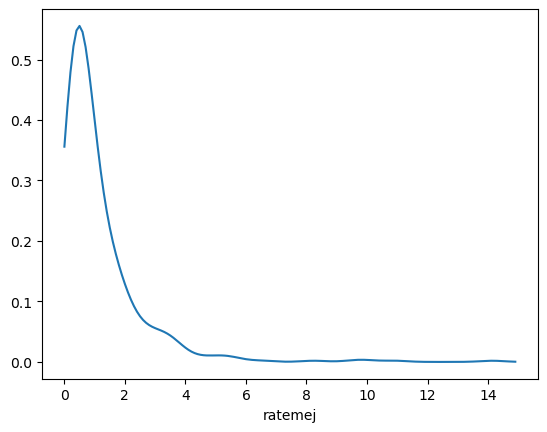

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


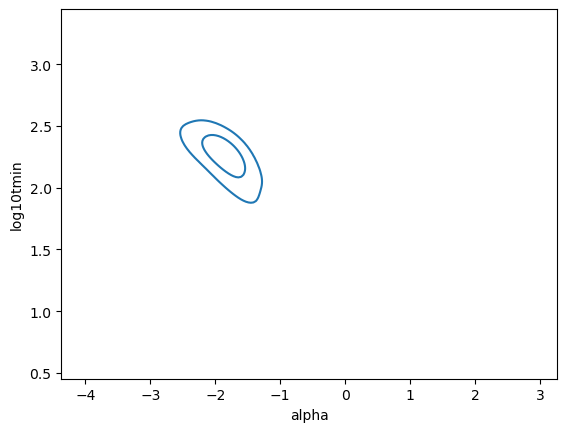

In [4]:
# build kdes for alpha-log10tmin and ratemej priors

prior_ratemej = gaussian_kde(samples['ratemej'])

ratemej_grid = np.arange(0.,15.,0.1)
plt.plot(ratemej_grid,prior_ratemej(ratemej_grid))

plt.xlabel('ratemej')
plt.show()

prior_alphalog10tmin = gaussian_kde(np.row_stack((samples['alpha'],samples['log10tmin'])))

alpha_grid = np.arange(-3.,2.,0.1)
log10tmin_grid = np.arange(1.,3.,0.1)
x,y = np.meshgrid(alpha_grid,log10tmin_grid)
sns.kdeplot(x=x.ravel(),y=y.ravel(),weights=prior_alphalog10tmin(np.vstack([x.ravel(),y.ravel()])),levels=[0.1,0.5])

plt.xlabel('alpha')
plt.ylabel('log10tmin')
plt.show()

In [5]:
# load disk star observations and make gaussian likelihood model for each datapoint

FeHs, EuFes, FeH_errs, EuFe_errs = np.loadtxt(OBSPATH, unpack=True, delimiter=',', skiprows=1)

like_means = []
like_stds = []

for fe,eu,fe_err,eu_err in zip(FeHs, EuFes, FeH_errs, EuFe_errs):

    mean = np.array([fe,eu])
    std = np.array([[fe_err,0.],[0.,eu_err]])
    
    like_means += [mean]
    like_stds += [std]   

# load disk+halo star observations for plotting

FeHs2, EuFes2, FeH_errs2, EuFe_errs2 = np.loadtxt(OBSPATH2, unpack=True, delimiter=',', skiprows=1)

In [6]:
# define prior, likelihood and posterior for mcmc

alpha_min, alpha_max = -4., 3.
log10tmin_min, log10tmin_max = 0.5, 3.
ratemej_min, ratemej_max = 0., 15.

def log_prior(theta):
    
    alpha,log10tmin,ratemej = theta
    
    if alpha > alpha_max or alpha < alpha_min: return -np.inf
    if log10tmin > log10tmin_max or log10tmin < log10tmin_min: return -np.inf
    if ratemej > ratemej_max or ratemej < ratemej_min: return -np.inf
    
    return np.log(prior_ratemej(ratemej)*prior_alphalog10tmin((alpha,log10tmin)))

def log_likelihood(theta, like_means, like_stds):
    
    alpha,log10tmin,ratemej = theta
    
    b_NS = -alpha
    tmin_NS = 1e-3*10.**log10tmin
    
    FeH_track, EuFe_track, rate_evs = rproc_evolution(1.,ratemej/1.,b_NS,tmin_NS,0.,0.5,NSTP)

    track = np.column_stack((FeH_track,EuFe_track))
    track = track[np.where(track[:,1] >= -5.)[0][0]:]
    track = track[~np.isnan(track[:,1])]
    if len(track) < 1: return -np.inf
    
    loglikes = [np.log(np.trapz(multivariate_normal(mean,std).pdf(track),track[:,0])) for mean,std in zip(like_means,like_stds)]
    
    return np.sum(loglikes)

def log_posterior(theta, like_means, like_stds):
    
    logprior = log_prior(theta)
    
    if not np.isfinite(logprior): return -np.inf
    
    return logprior + log_likelihood(theta, like_means, like_stds)

In [7]:
# do mcmc sampling with emcee

NWALK = 16
NDIM = 3
NPOST = 10
NBURN = 1

init = np.empty((NWALK, NDIM))
init[:, 0] = np.random.uniform(alpha_min, alpha_max, NWALK)
init[:, 1] = np.random.uniform(log10tmin_min, log10tmin_max, NWALK)
init[:, 2] = np.random.uniform(ratemej_min, ratemej_max, NWALK)

with multiprocessing.Pool(NWALK) as pool:
    print('running')
    sampler = emcee.EnsembleSampler(NWALK, NDIM, log_posterior, args=(like_means, like_stds), pool=pool)
    start = time.time()
    sampler.run_mcmc(init, NPOST, progress=True)
    end = time.time()
    elapsed = end - start
    print("Multiprocessing took {0:.1f} min".format(elapsed/60.))

chain = sampler.get_chain()
try: acls = sampler.get_autocorr_time(quiet=True)
except : acls = [1.]
flat_samples = sampler.get_chain(flat=True)[NBURN::int(max(acls))]
log_prob = sampler.get_log_prob()[NBURN::int(max(acls))]

/tmp/ipykernel_1180113/680222408.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_ratemej(ratemej)*prior_alphalog10tmin((alpha,log10tmin)))
/tmp/ipykernel_1180113/680222408.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_ratemej(ratemej)*prior_alphalog10tmin((alpha,log10tmin)))
/tmp/ipykernel_1180113/680222408.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_ratemej(ratemej)*prior_alphalog10tmin((alpha,log10tmin)))
/tmp/ipykernel_1180113/680222408.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_ratemej(ratemej)*prior_alphalog10tmin((alpha,log10tmin)))
/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_1180113/680222408.py:15: RuntimeWarning: divide by ze

running


/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:362: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:362: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in power
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in power
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354

Multiprocessing took 13.9 min


/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

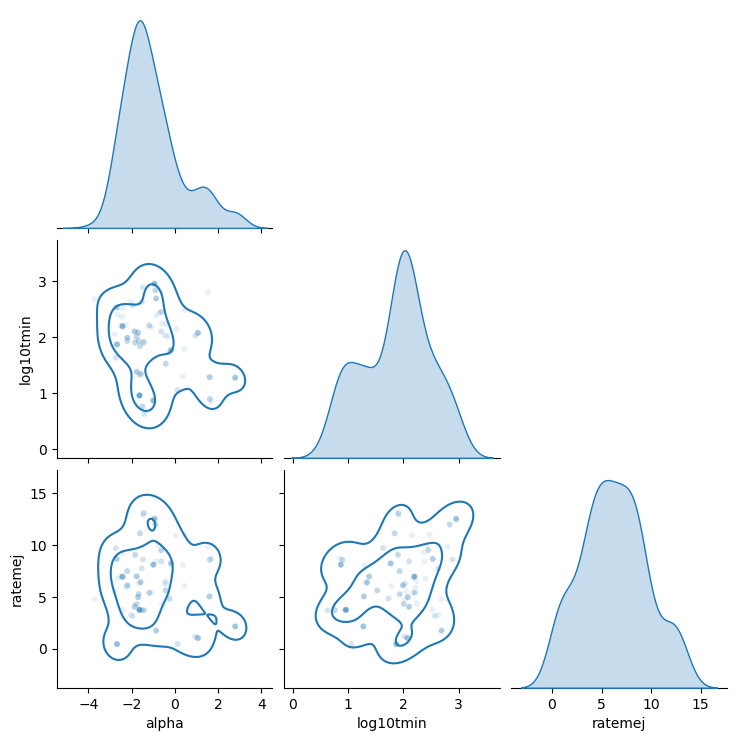

In [17]:
# plot mcmc samples

df = pd.DataFrame(flat_samples,columns=('alpha','log10tmin','ratemej'))
g = sns.pairplot(df,corner=True,diag_kind='kde',plot_kws={'size': 2, 'alpha': 0.1})
g.map_offdiag(sns.kdeplot,levels=[0.1,0.5])
plt.show()

In [28]:
# compute predicted galactic r-process enrichment histories

FeH_grid = np.linspace(FEH_MIN,FEH_MAX,NFEH)
EuFe_pts = []

for i,(alpha,log10tmin,ratemej) in tqdm(enumerate(flat_samples)):
    
    b_NS = -alpha
    tmin_NS = 1e-3*10.**log10tmin
    
    FeH_track, EuFe_track, rate_evs = rproc_evolution(1.,ratemej/1.,b_NS,tmin_NS,0.,0.5,NSTP)
    
    track = np.column_stack((FeH_track,EuFe_track))
    track = track[np.where(track[:,1] >= -5.)[0][0]:]
    track = track[~np.isnan(track[:,1])]
    
    EuFe_of_FeH = interp1d(FeH_track,EuFe_track,bounds_error=False)
    EuFe_pts += [EuFe_of_FeH(FeH_grid)]
    
EuFe_pts = np.array(EuFe_pts)

0it [00:00, ?it/s]/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: divide by zero encountered in power
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:362: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in power
  result = C * heaviside(t-tmin,1.) / t**b
2it [01:16, 34.63s/it

In [6]:
# calculate abundance history confidence envelopes

CLS = [0.68,0.9]
md, qs = [], []

def wtquantile(xs,qs,wts=[]):
    
    nan_idxs = np.isnan(xs)
    xs = np.array(xs[~nan_idxs])
    
    num_xs = len(xs)
    qs = np.array(qs, ndmin=1)
    if len(xs) < 1: return np.full(2*len(qs),np.nan)
    elif len(xs) == 1: return np.full(2*len(qs),xs[0])
    if len(wts) < 1: wts = np.full(num_xs, 1.)
    else: wts = np.array(wts[~nan_idxs])
    
    ps = wts/np.sum(wts)
    xs_sorted,ps_sorted = zip(*sorted(list(zip(xs,ps)),reverse=False))

    Ps = np.cumsum(ps_sorted)

    idxs_lb = np.array([np.where(Ps >= (1.-q)/2.)[0][0] for q in qs])
    idxs_ub = np.array([np.where(Ps >= 1.-(1.-q)/2.)[0][0] for q in qs])
    xs_sorted = np.array(xs_sorted)

    return list(xs_sorted[idxs_lb])+list(xs_sorted[idxs_ub])

for i in range(NFEH):
    
    qs += [wtquantile(EuFe_pts[:,i],[0.68,0.9])]
    md += [wtquantile(EuFe_pts[:,i],0.)]
    
qs = np.array(qs)

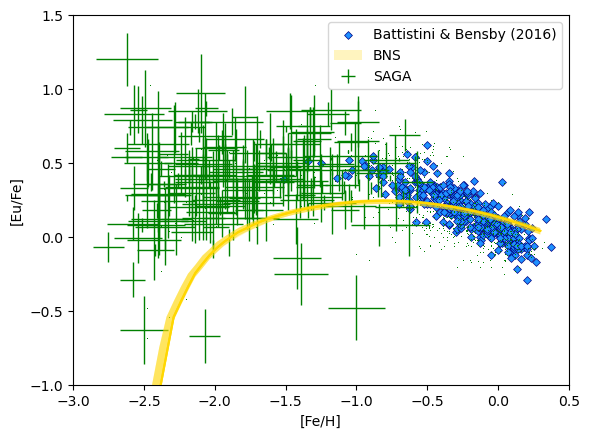

In [7]:
# plot EuFe vs FeH tracks conditioned on stellar observations

plt.figure(figsize=(6.4,4.8))

plt.errorbar(FeHs2, EuFes2, xerr=[FeH_errs2,FeH_errs2], yerr=[EuFe_errs2,EuFe_errs2], c='g', fmt=',', lw=1, label='SAGA')
plt.scatter(FeHs, EuFes,marker='D',facecolor='dodgerblue',edgecolor='navy', s=16, lw=0.5, label='Battistini & Bensby (2016)')

plt.fill_between(FeH_grid,qs[:,1],qs[:,3],facecolor='gold',edgecolor=None,alpha=0.25, label='BNS',zorder=10) # 90% CI
plt.fill_between(FeH_grid,qs[:,0],qs[:,2],facecolor='gold',edgecolor=None,alpha=0.5,zorder=10) # 68% CI

plt.plot(FeH_grid,md,c='gold',zorder=10) # median

plt.xlim(-3.,0.5)
plt.ylim(-1.,1.5)
plt.xlabel('[Fe/H]')
plt.ylabel('[Eu/Fe]')
plt.legend(frameon=True,loc='upper right')
plt.show()

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

<Figure size 640x240 with 0 Axes>

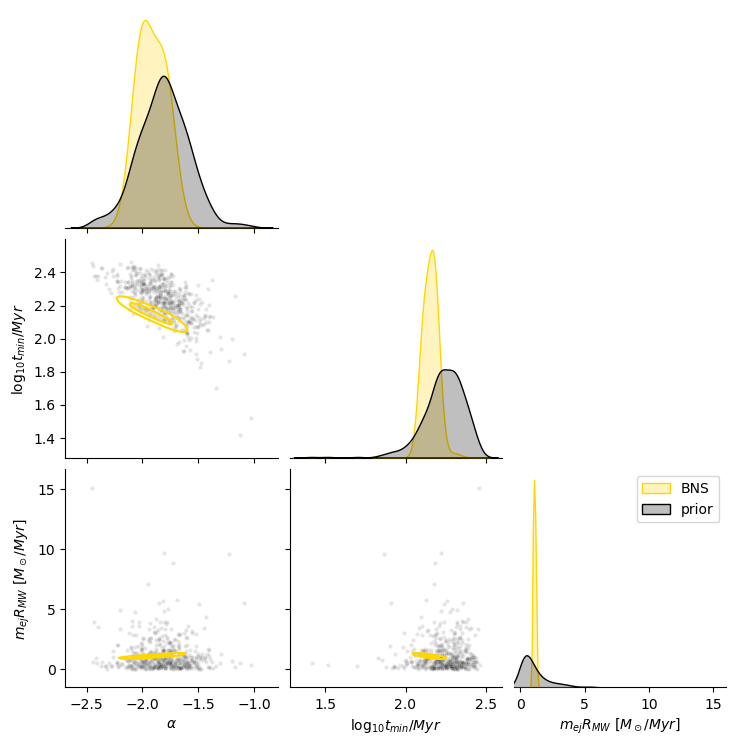

In [8]:
# plot DTD parameter and rate-mej posterior

plt.figure(figsize=(6.4,2.4))

fig = sns.pairplot(samples,vars=['alpha','log10tmin','ratemej'],kind='scatter',diag_kind='kde',plot_kws={'color': 'k','alpha': 0.1},diag_kws={'color': 'gold', 'label': 'BNS'},markers='.',corner=True)
fig.map_diag(sns.kdeplot,color='k',fill=True,label='prior')
fig.map_offdiag(sns.kdeplot,levels=[0.5,1.],color='gold',fill=True,alpha=0.25)
fig.map_offdiag(sns.kdeplot,levels=[0.1,0.5],color='gold')

ylbls = [r'$\alpha$',r'$\log_{10}t_{min}/Myr$','',r'$m_{ej}R_{MW}~[M_\odot/Myr]$',r'$m_{ej}R_{MW}~ [M_\odot/Myr]$','']
i = 0
for ax in fig.axes.flatten():
    if ax is not None: 
        ax.set_ylabel(ylbls[i])
        i += 1

xlbls = ['',r'$\alpha$','',r'$\alpha$',r'$\log_{10}t_{min}/Myr$',r'$m_{ej}R_{MW}~[M_\odot/Myr]$']
i = 0
for ax in fig.axes.flatten():
    if ax is not None: 
        ax.set_xlabel(xlbls[i])
        i += 1

plt.xlim(-0.5,16.)
plt.legend(frameon=True,loc='upper right')
plt.show()